In [1]:
import torch
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.autograd import Variable
from utilities import *
device='cpu'


In [2]:
focal, all_c2w, all_gt = get_data()

LOAD DATA ../nerf_example_data/nerf_synthetic/lego/train


100%|██████████| 100/100 [00:05<00:00, 19.58it/s]


In [3]:
H, W = all_gt[0].shape[:2]

In [4]:
rays_or_dir = [get_rays_np(H,W, focal, c2w) for c2w in all_c2w]

In [5]:
camera_centers = get_cameras_centers(rays_or_dir)

In [6]:
class VoxelGrid():
    def __init__(self, size=128, bound_w=1):
        self.size = size
        self.bound_w = bound_w
        self.colors =  Variable(torch.rand((size*size*size,3)).to(device), requires_grad=True)
        self.opacities =  Variable(torch.rand((size*size*size)).to(device), requires_grad=True)


        x = np.linspace(-bound_w,bound_w,size)
        y = np.linspace(-bound_w,bound_w,size)
        z = np.linspace(0,bound_w,size)
        self.meshgrid = np.meshgrid(x,y,z)

    def in_bounds_indices(self, p):
        ''' input: Nx3 array
            output: index of valid arrays'''
        in_x = (p[:,0]>=0)*(p[:,0]<self.size)
        in_y = (p[:,1]>=0)*(p[:,1]<self.size)
        in_z = (p[:,2]>=0)*(p[:,2]<self.size)
        return torch.arange(len(p))[in_x*in_y*in_z]
    
    def descartes_to_indices(self, p):
        ''' input: Nx3 array, 3D points
            out: Nx3 array, 3D indices in [0, size['''
        q = torch.zeros_like(p)
        q[:, 0] = (p[:,0]+self.bound_w)/(2*self.bound_w)*(self.size-1)
        q[:, 1] = (p[:,1]+self.bound_w)/(2*self.bound_w)*(self.size-1)
        q[:, 2] = p[:,2]/(self.bound_w)*(self.size-1)
        return q

    def flatten_3d_indices(self, inds_3d):
        ''' input: Nx3 array of indices
            out: N array of flatten indices'''
        return inds_3d[:,0] + self.size*inds_3d[:,1] + self.size*self.size*inds_3d[:,2]

    def render_ray(self, p):
        # extract valid indices

        inds_3d = self.descartes_to_indices(p)
        valid_inds = self.in_bounds_indices(torch.floor(inds_3d))

        # meshgrid coordinates
        mesh_coords = self.flatten_3d_indices(inds_3d[valid_inds].long())

        colors = self.colors[mesh_coords]
        opacities = self.opacities[mesh_coords]

        cumsum_opacities = torch.cumsum(opacities, 0)
        
        transp_term = torch.exp(-cumsum_opacities)*(1-torch.exp(-opacities))
        return (colors*transp_term[..., None]).sum(0)

    def update_grads(self, lr):
        self.colors.data -= lr * self.colors.grad.data
        self.colors.grad.data.zero_()
        self.opacities.data -= lr * self.opacities.grad.data
        self.opacities.grad.data.zero_()

In [7]:
VG = VoxelGrid(20, 1.5)
xx,yy,zz = VG.meshgrid

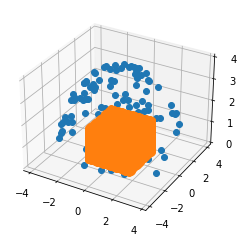

In [8]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot( camera_centers[:,0], camera_centers[:,1], camera_centers[:,2], 'o')
ax.plot( xx.flatten(),yy.flatten(),zz.flatten(), 'o')


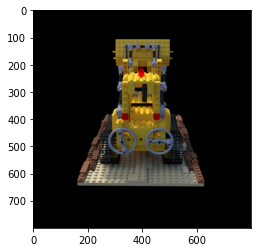

In [9]:
plt.imshow(all_gt[0])

In [10]:
rays_or_dir = get_rays_np(H,W, focal, all_c2w[0])

In [11]:
rays_or_dir[1][0,0]

array([ 0.37436787, -1.05665646,  0.04333576])

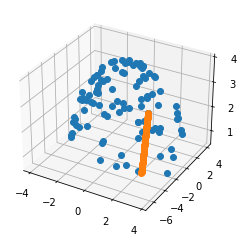

In [12]:
p = rays_or_dir[0][0,0]+ np.arange(100)[:, None]/10*rays_or_dir[1][0,0]
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.plot( camera_centers[:,0], camera_centers[:,1], camera_centers[:,2], 'o')
ax.plot( p[:,0], p[:,1], p[:,2], 'o')

In [13]:
# target_im = all_gt[0]
# rays = rays_or_dir[0][..., None] + np.arange(100)/10*rays_or_dir[1][..., None]

red = 8
target_im = all_gt[0][::red,::red,:]
rays = rays_or_dir[0][::red,::red,:, None] + np.arange(100)/10*rays_or_dir[1][::red, ::red,:, None]



In [14]:
target_im.shape

(100, 100, 3)

In [27]:

losses=[]
for x in tqdm(range(target_im.shape[0])):
    for y in range(target_im.shape[0]):
        # x = np.random.randint(0,800)
        # y = np.random.randint(0,800)

        pixel_target = torch.tensor(target_im[x,y])

        ray = torch.tensor(rays[x,y].T, dtype=torch.float32)

        pix_estim = VG.render_ray(ray)

        loss = ((pix_estim-pixel_target)**2).sum()

        loss.backward()
        losses.append(loss.item())

        VG.update_grads(0.1)



100%|██████████| 100/100 [00:07<00:00, 13.62it/s]


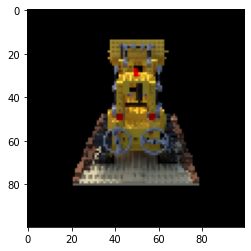

In [28]:
plt.imshow(target_im)

In [29]:
n_red = 5

new_im = np.zeros_like(target_im)
for x in tqdm(range(target_im.shape[0])):
    for y in range(target_im.shape[1]):
        ray = torch.tensor(rays[x,y].T, dtype=torch.float32)

        pix_estim = VG.render_ray(ray)
        new_im[x,y, :] = pix_estim.detach().numpy()

100%|██████████| 100/100 [00:05<00:00, 19.64it/s]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


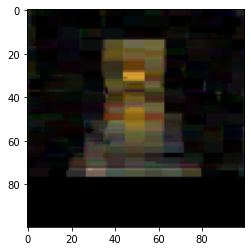

In [30]:
%matplotlib inline
plt.imshow(new_im)

(array([2.500e+01, 8.640e+02, 2.064e+03, 2.095e+03, 2.130e+03, 7.510e+02,
        4.500e+01, 1.800e+01, 7.000e+00, 1.000e+00]),
 array([-0.42758888, -0.15863408,  0.11032071,  0.37927551,  0.6482303 ,
         0.9171851 ,  1.18613989,  1.45509469,  1.72404948,  1.99300428,
         2.26195908]),
 <BarContainer object of 10 artists>)

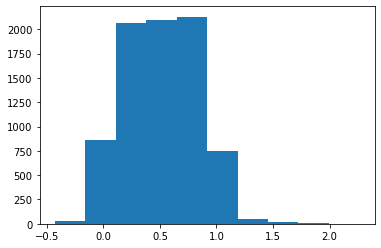

In [31]:
plt.hist(VG.opacities.tolist())